In [1]:
import numpy as np
import json
import os
import random
import matplotlib.pyplot as plt

## Loading data to use as reference (annotazioni fatte a mano da Andrea)

In [2]:
annotations_qa_root = '/media/data7/DATASET/shapenerf_objanerf_text/spatial_gpt4point_qa/texts'
with open(os.path.join(annotations_qa_root, 'spatial_gpt4point_qa_no_vec.json'), 'r') as f:
    annotations_qa = json.load(f)
print(len(annotations_qa))
print(annotations_qa[0])  

annotations_cap_root = '/media/data7/DATASET/shapenerf_objanerf_text/spatial_gpt4point_cap/texts'
with open(os.path.join(annotations_cap_root, 'spatial_gpt4point_cap.json'), 'r') as f:
    annotations_cap = json.load(f)
print(len(annotations_cap))
print(annotations_cap[0])

data_root = '/media/data7/DATASET/objanerf_text_evaluation_data/imgs_from_objaverse/gpt4point_test'

190
{'object_id': '44795759d6144f61990796c02088665f', 'conversations': [{'from': 'human', 'value': 'What is the rabbit wearing around its neck?\nA: A red necklace\nB: A red tie\nC: A red scarf'}, {'from': 'gpt', 'value': 'C: A red scarf'}]}
100
{'object_id': '1915ece903a5406d8b59b3af3954b943', 'conversations': [{'from': 'human', 'value': '<point>\nProvide a very detailed description of the object knowing that its caption is: "A low-polygon, golden trophy with a small handle base.". Focus on the relative positions of the parts of the object. Include as many details as possible. Do not hallucinate. Focus only on the content of the images. Focus only on the foreground.'}, {'from': 'gpt', 'value': "The trophy is a three-dimensional object with a smooth, golden surface. It has a cylindrical body with a slightly flared top and a very thin circular base. The trophy has two handles: one on each side. The trophy's design is simplistic, with no visible textures or patterns, giving it a uniform a

In [3]:
object_ids = [annotation['object_id'] for annotation in annotations_qa]
object_ids = list(set(object_ids))
print(len(object_ids))

random_id = random.choice(object_ids)
print(random_id)

98
ba341c4ce89647ea9f6996ec58e3eacf


ba341c4ce89647ea9f6996ec58e3eacf
Q 1: Where are the tractors located in relation to each other?
A: Next to each other
B: One on one side of the scene and one on the other
C: One behind the other
====  A: Next to each other  ==== 


Question: <point>
Provide a very detailed description of the object knowing that its caption is: A scene with two tractors, a loader, and a trailer parked on a plot of land with plenty of wood waiting to be loaded.. Focus on the relative positions of the parts of the object. Include as many details as possible. Do not hallucinate. Focus only on the content of the images. Focus only on the foreground.
GT:  This is a 3D scene with two tractors, a loader, and a trailer parked on a plot of land with plenty of wood waiting to be loaded. The tractors are positioned side by side, with the loader attached to one of them. The trailer is parked in front of the tractors, and the wood is stacked neatly beside the tractors. The ground appears to be a mix of dirt and patc

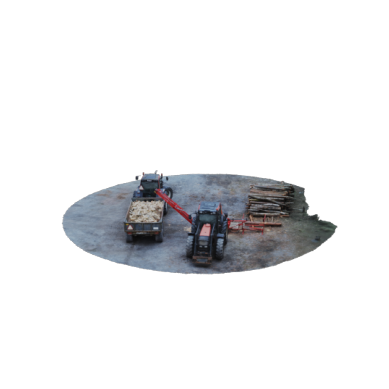

In [4]:
qa = [annotation for annotation in annotations_qa if annotation['object_id'] == random_id]
cap = [annotation for annotation in annotations_cap if annotation['object_id'] == random_id]
#print('QA annotations:', qa[0]['conversations'][0]['value'])
print(random_id)
for i, q in enumerate(qa):
    print(f'Q {i+1}: {q["conversations"][0]["value"]}')
    print('==== ', q['conversations'][1]['value'], ' ==== ')
    print('\n')

print('Question:', cap[0]['conversations'][0]['value'])
print('GT: ', cap[0]['conversations'][1]['value'])
image_path = os.path.join(data_root, random_id, '018.png')
plt.imshow(plt.imread(image_path))
plt.axis('off')
plt.show()

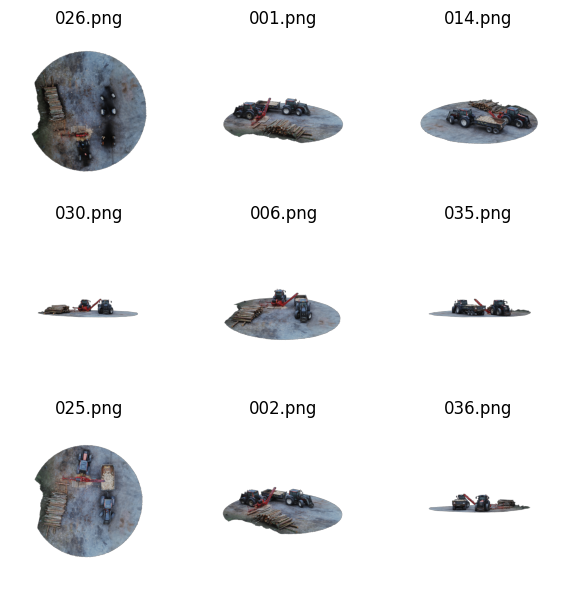

In [5]:
# visualize a grid with all the images of the object
def visualize_object_images(object_id, data_root, num_images=9):
    object_path = os.path.join(data_root, object_id)
    image_files = [f for f in os.listdir(object_path) if f.endswith('.png')]
    random.shuffle(image_files)
    image_files = image_files[:num_images]

    fig, axs = plt.subplots(3, 3, figsize=(6, 6))
    axs = axs.flatten()

    for ax, img_file in zip(axs, image_files):
        img_path = os.path.join(object_path, img_file)
        ax.imshow(plt.imread(img_path))
        ax.axis('off')
        ax.set_title(img_file)

    plt.tight_layout()
    plt.show()

visualize_object_images(random_id, data_root, num_images=9)

# Run VLM on input images

In [6]:
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
from transformers import pipeline
import torch

/home/mgaliazzo/.pyenv/versions/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
os.system('export CUDA_HOME=/usr/local/cuda-12.4')
os.system('export PATH=$CUDA_HOME/bin:$PATH')
os.system('export LD_LIBRARY_PATH=$CUDA_HOME/lib64:$LD_LIBRARY_PATH')

0

In [8]:
model_id = "llava-hf/llava-interleave-qwen-7b-hf"
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16)

In [9]:
# load LLaVA model

device = 'cuda:3'
llava = LlavaForConditionalGeneration.from_pretrained(
        model_id, 
        low_cpu_mem_usage=True, 
        quantization_config=bnb_config, 
        device_map=device
    )

llava.eval()

Loading checkpoint shards: 100%|██████████| 4/4 [00:11<00:00,  2.86s/it]


LlavaForConditionalGeneration(
  (model): LlavaModel(
    (vision_tower): SiglipVisionModel(
      (vision_model): SiglipVisionTransformer(
        (embeddings): SiglipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
          (position_embedding): Embedding(729, 1152)
        )
        (encoder): SiglipEncoder(
          (layers): ModuleList(
            (0-25): 26 x SiglipEncoderLayer(
              (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
              (self_attn): SiglipAttention(
                (k_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                (v_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                (q_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                (out_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
              )
              (layer_norm2): LayerNorm((1152,), eps=1e-

In [10]:
llava_processor = AutoProcessor.from_pretrained(model_id)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [18]:
cap[0]['conversations'][1]['value']

'This is a 3D scene with two tractors, a loader, and a trailer parked on a plot of land with plenty of wood waiting to be loaded. The tractors are positioned side by side, with the loader attached to one of them. The trailer is parked in front of the tractors, and the wood is stacked neatly beside the tractors. The ground appears to be a mix of dirt and patches of grass, and there are no visible signs of recent activity, suggesting the scene might be a still moment in time.'

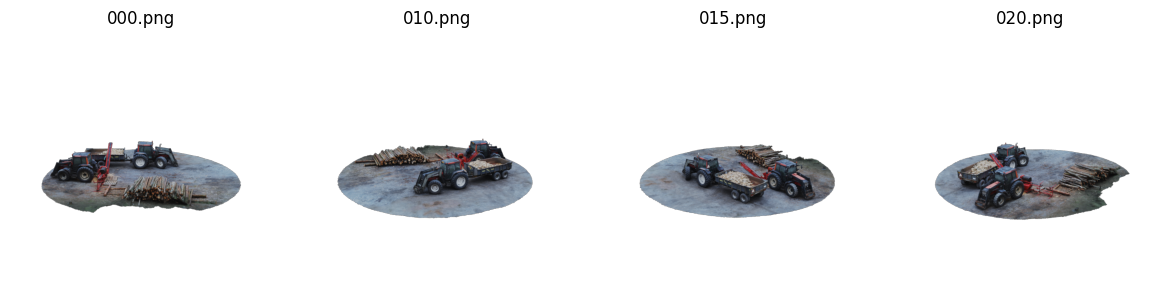

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


--------------- NORMAL QUESTION ---------------
user


You are an AI assistant tasked with generating detailed multiple-choice questions and their corresponding answers based on the images provided.

### Task:
Generate one detailed multiple-choice question about the object(s) or scene depicted in the provided images.

### Constraints:
1.  **Relative References Only:** Since the scene can be viewed from multiple perspectives and may not have a fixed orientation, all questions and options must use *only* relative points of reference (e.g., "to the left of [object A]", "above [object B]", "between [object X] and [object Y]").
2.  **Detailed Questions:** The questions should require careful observation of the image.
3.  **Distinct Options:** Provide three distinct options for each question.
4.  **Correct Answer:** One option must be clearly correct based on the image.

### Output Format:
For each question-answer pair, you MUST follow this format precisely:

Q: [Your Question Text Here]
1. 

In [32]:
image_names = ['000.png', '010.png', '015.png', '020.png']
images = [os.path.join(data_root, random_id, img_name) for img_name in image_names]

fig, axs = plt.subplots(1, len(images), figsize=(12, 3))
for ax, img_path in zip(axs, images):
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(os.path.basename(img_path))
plt.tight_layout()
plt.show()

# question = """
# You are given 4 images and must generate a multiple-choice question and its answer about the object(s) visible in the image. 
# Don't make questions about absolute positions of the objects in the images, just relative positions.

# Each question must follow this format exactly:

# Q: [Your question here]
# 1. [First answer option]
# 2. [Second answer option]
# 3. [Third answer option]
# A: [Correct option number and text, copied exactly from above]
# """

question = """
You are an AI assistant tasked with generating detailed multiple-choice questions and their corresponding answers based on the images provided.

### Task:
Generate one detailed multiple-choice question about the object(s) or scene depicted in the provided images.

### Constraints:
1.  **Relative References Only:** Since the scene can be viewed from multiple perspectives and may not have a fixed orientation, all questions and options must use *only* relative points of reference (e.g., "to the left of [object A]", "above [object B]", "between [object X] and [object Y]").
2.  **Detailed Questions:** The questions should require careful observation of the image.
3.  **Distinct Options:** Provide three distinct options for each question.
4.  **Correct Answer:** One option must be clearly correct based on the image.

### Output Format:
For each question-answer pair, you MUST follow this format precisely:

Q: [Your Question Text Here]
1. [Option 1 Text]
2. [Option 2 Text]
3. [Option 3 Text]
A: [Correct Option Number]. [Full Text of Correct Option]

### Example of Output Format:
(Imagine an image shows a red apple to the left of a green pear)

Q: What fruit is located to the immediate right of the red apple?
1. A blue banana
2. A green pear
3. An orange orange
A: 2. A green pear

---
Now, based on the provided images, generate the 3 questions and answers following all the above instructions and the specified format.
"""

# build conversation
conversation = [
                {
                    "role": "user",
                    "content": [
                        *[{"type": "image", "image": img} for img in images],
                        {"type": "text", "text": question}
                    ],
                }
            ]
            
# Process with VLM
inputs = llava_processor.apply_chat_template(
    [conversation], 
    add_generation_prompt=True, 
    tokenize=True, 
    return_dict=True, 
    return_tensors="pt"
).to(device)

# Move inputs to device
inputs = {k: v.to(device) for k, v in inputs.items()}

# Generate with optimized parameters
generate_ids = llava.generate(**inputs, max_new_tokens=128,)
outputs = llava_processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)

print("-" * 15 + " NORMAL QUESTION " + "-" * 15)
print(outputs[0] + "\n")

# question_with_caption = 'you are given the caption "' + cap[0]['conversations'][1]['value'] + '". by using the caption' + question

# # build conversation
# conversation = [
#                 {
#                     "role": "user",
#                     "content": [
#                         {"type": "text", "text": question_with_caption},
#                         *[{"type": "image", "image": img} for img in images]
#                     ],
#                 }
#             ]
            
# # Process with VLM
# inputs = llava_processor.apply_chat_template(
#     [conversation], 
#     add_generation_prompt=True, 
#     tokenize=True, 
#     return_dict=True, 
#     return_tensors="pt"
# ).to(device)

# # Move inputs to device
# inputs = {k: v.to(device) for k, v in inputs.items()}

# # Generate with optimized parameters
# generate_ids = llava.generate(**inputs, max_new_tokens=128,)
# outputs_with_caption = llava_processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)

# print("-" * 15 + " QUESTION WITH CAPTION " + "-" * 15)
# print(outputs_with_caption[0])